* Home Ownership - домовладение  
* Annual Income - годовой доход  
* Years in current job - количество лет на текущем месте работы  
* Tax Liens - налоговые обременения  
* Number of Open Accounts - количество открытых счетов  
* Years of Credit History - количество лет кредитной истории  
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)  
* Number of Credit Problems - количество проблем с кредитом  
* Months since last delinquent - количество месяцев с последней просрочки платежа  
* Bankruptcies - банкротства  
* Purpose - цель кредита  
* Term - срок кредита  
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)  
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)  
* Monthly Debt - ежемесячный долг  
* Credit Score - баллы кредитного рейтинга  
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
from typing import List, Optional
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import shap

from tqdm.notebook import tqdm

import re
import os

from functools import partial
from scipy.stats import mode
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
# import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.manifold import TSNE
# import optuna
import catboost as cb

from View import MyClass
mc = MyClass()

In [2]:
def subb(test, model):
    pred = model.predict_proba(test)

    pred = pred[:,1]
    pred = np.where(pred>0.4, 1, 0)

    sub['Credit Default'] = pred
    sub.to_csv('submission/sample_submission.csv', index=False)

In [3]:
def shap_shap(X_train, model, shap_limit=0):
    np.random.seed(10)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Суммированная важность признаков
#     shap.summary_plot(
#         shap_values, X_train, plot_type="bar", max_display=50)   # строит график важности признаков
    
    shap_values_importance = pd.DataFrame({
    "importance": np.abs(shap_values).mean(axis=0),
    "feature": X_train.columns
        })
    shap_values_importance = shap_values_importance.sort_values(
        by="importance", ascending=False
        )
    shap_values_importance = shap_values_importance.reset_index(drop=True) 
    
    
#     print(shap_values_importance)
    # Набор топ признаков
    best_feature = shap_values_importance.feature.to_list()
    dict_features = dict(zip(best_feature, shap_values_importance["importance"]))
    # Набор признаков для удаления
    features_to_drop = shap_values_importance[shap_values_importance["importance"] <= shap_limit]
    features_to_drop = features_to_drop.feature.to_list()
    
    return features_to_drop, dict_features

In [4]:
def fit_kfold(data, cat_features=[], threshold = 0.4, fold = 10, best_sign=5):
    X = data.drop(columns = ['target'], axis = 1)
    Y = data['target']
    cat_preds = list()
    bad_features, best_features =  list(), list()
    dict_fold = dict()

    params = {
        "n_estimators": 1993,
        "learning_rate": 0.009906548674016816,
        "subsample": 0.5000411100811685,
#         'colsample_bylevel': 0.5853177112754828,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": False,
        "max_depth": 5,
        "l2_leaf_reg": 20,
        "early_stopping_rounds": 100,
#         "thread_count": 6,
        "random_seed": 42,
        "class_weights" : (1, 2),
        "random state": 42
        }
    
    sk = RepeatedStratifiedKFold(n_splits = fold, n_repeats = 1, random_state = 42)
    for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
#         X_train, X_valid, Y_train, Y_valid = X_train[:4500], X_train[4500:], Y_train[:4500], Y_train[4500:]
        dict_fold[f"{i}_train"] = [train_idx]
        dict_fold[f"{i}_test"] = [test_idx]
        
        if len(cat_features) != 0:
            print("тут")
            Cat_md = cb.CatBoostClassifier(**params, cat_features=cat_features)
        else:
            Cat_md = cb.CatBoostClassifier(**params)
        
#         Cat_md.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])
        Cat_md.fit(X_train, Y_train)
        
#         cat_pred = Cat_md.predict(X_test)
        cat_pred = Cat_md.predict_proba(X_test)[:, 1]
        cat_pred = np.where(cat_pred > threshold, 1, 0)
        cat_score = roc_auc_score(Y_test, cat_pred)
        cat_preds.append(cat_score)
        print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)
        bad, dict_ = shap_shap(X_train, Cat_md)
#         print(dict_)
        bad_features.append(bad)
        best_features.append(list(dict_.keys())[:best_sign])
    bad_features = set(list(np.array(bad_features).flat))
    best_features = set(list(np.array(best_features).flat))
    print(f'Средняя совокупность оценок ROC-AUC за {fold}-кратный период составляет', np.mean(cat_preds))
    print(f"Признаки для удаления {bad_features}")
    print(f"Лучших {best_sign}  признаков: {best_features}")
    return Cat_md, dict_fold

In [5]:
def fit_score(X, cat=False):
    x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split_dis(X, "target")

    params = {
        "n_estimators": 1000,
        "learning_rate": 0.01,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": 500,
        "max_depth": 6,
        "l2_leaf_reg": 10,
        "early_stopping_rounds": 100,
        "thread_count": 6,
        "random_seed": 42,
        "class_weights" : (1, 2)
        }
    if cat:
        print("тут")
        model = cb.CatBoostClassifier(**params, cat_features=cat)
    else:
        model = cb.CatBoostClassifier(**params)
    
#     model.fit(x_train, y_train, eval_set=(x_valid, y_valid)
#                       )
#     model.fit(x_train, y_train
#                       )
    
# #                 y_pred = model.predict(x_test)
# #                 score = roc_auc_score(y_test, y_pred)
# #                 print("roc_auc_score: ", score)
# #                 print("confusion_matrix: ", confusion_matrix(y_test, y_pred))
# #                 print("accuracy_score: ", accuracy_score(y_test, y_pred))
    model, rocauc_score = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=params)
    pred = model.predict_proba(x_test)[:,1]
    pred = np.where(pred > 0.7, 0, 1)
    print("test score: ", round(roc_auc_score(pred, y_test), 5))
    return model, x_train

In [6]:
class MissedColumnsError(Exception):
    pass

class CategoricalFrequencyTransformer(BaseEstimator, TransformerMixin):
    """
    Трансформер для осуществляения FrequencyEncoding, кодирование
    признаков с помощью частотного анализа.

    Parameters
    ----------
    use_cols: List[str]
        Список с названием признаков, для которых нужно
        применить преобразование.

    Attributes
    ----------
    feature_mappers: dict
        Словарь со словарем преобразования для каждого
        признака, перечисленного в self.use_cols.

    """
    def __init__(self, use_cols: List[str]) -> None:
        self.use_cols = use_cols

    def _check_data(self, X):
        """
        Проверка наличия признаков в self.user_cols во
        входящей матрице признаков. Если признак отсутствует
        в X, то возбуждается исключение MissedColumnsError.

        """
        missed_cols = list(set(self.use_cols) - set(X.columns))
        if missed_cols:
            raise MissedColumnsError(
                f"Missed columns: {missed_cols}"
            )

    def fit(self, X, y=None):
        """
        Вычисление частот для заданных признаков.

        Parameters
        ----------
        X: array-like, shape = [n_samples, n_features]
            Матрица признаков для вычисления частот.

        Returns
        -------
        self

        """
        self._check_data(X)
        self.feature_mappers = {}

        for feature in self.use_cols:
            unique, counts = np.unique(X[feature], return_counts=True)
            mapper = pd.Series(data=counts, index=unique)
            self.feature_mappers[feature] = mapper

        return self

    def transform(self, X, y=None):
        # ToDO -> расширить использование на Numpy-объекты
        self._check_data(X)
        check_is_fitted(self, "feature_mappers")
        for feature in self.use_cols:
            mapper = self.feature_mappers.get(feature)
            X[feature] = X[feature].map(mapper)

        return X

In [7]:
print(mc.__doc__)

Визуализация и предобработка данных
_________________________________________________
* Метод "view_csv" принимает DataFrame и выводит данные о нем
возвращает categorical, numerical

* Метод "stat_frame" принимает DataFrame и возвращает DataFrame со статистиками

* Метод "corr" принимает DataFrame и target : str

Работа с даными
__________________________________________________

* Метод "median_mode" меняет в числовых данных пропуски на медиану, в категориальных на моду
* Метод "percentile_99_1" принимает data: DataFrame, data_stat : DataFrame( возвращает метод "stat_frame")
возвращат данные где больше 99 перцетиля и меньше 1(используется метод for, не рекомендуется где очень много столбцов)
* метод "shap" (model, X_train, shap_limit=0) выводит наиболеее важные признаки
model: model, X_train: данные на которых обучалась модель, shap_limit: порог для наихудших признаков
возвращает признаки с важностью с порогом равным или меньше (shap_limit)
и словарь признаков отсортированный по важно

Визуализация и предобработка данных  
# Первичный обзор работа с память  ю
* Метод "view_csv" принимает DataFrame и выводит данные о нем, переводит название столбцов в low  er
возвращает data.columns, categorical, numeri  cal
* Метод optim_memory оптимизирует память занимаемую данными, принимает DataFrame, возвращает DataF  r  ame

# Стат  истика
* Метод "stat_frame" принимает DataFrame и возвращает DataFrame со стати  стиками
* Метод "corr" принимает DataFrame и targ  et : str
* Метод corr_sign принимает data: DataFrame, drop_sign:List ( корреляция между пр  изнаками)
* Метод nonlianer_comun принимает data: DataFrame, numerical: list(список числовых   признаков
target: str(по умолчанию "class"), num_sign: int(кол-во столбцов с нелиней  ной связью)
* Метод "percentile_99_1" принимает data: DataFrame, data_stat : DataFrame( возвращает метод "stat_frame"),   flag: bool(
если флаг равен True возвращает фрейм где максимум заменен на 99 перцентиль, а минимум на   1 перцентиль)
по умолчани  ю flag = False
возвращат данные где больше 99 перцетиля и меньше 1(используется метод for, не рекомендуется где очень   много столбцов)
* Метод shap принимает данные на которых обучалась модель, саму модель и кол-во возврата   лучших признаков
возвращает для списка нулевых признаков и   лучших признаков
(model, X_train, shap_limit=0) model:model, X_train:DataFrame, shap_limit:int(порог для   плохих признаков)
return: признаки с порогом ниже заданного, все признаки, словарь {призн  ак: вес для модели}
* Метод dist_kmeans определяет кол-во кластеров для кластеризации(к  осинусное растояние)
(X, max_klaster=10), X: DataFrame, max_klas  ter: int(по умолч 10)
  



# Работа с данными
* Метод "object_to_freq" меняет созд  ает новые столбцы в данных,
где категориальные значения заме  няны на частоту их вхождения
* Метод "median_mode" меняет в числовых данных пропуски на меди  ану, в категориальных на моду
* Метод "recursive_fillna_kmeans" заполняет пропус  ки путем кластеризации, KMeans
принимает data:DataFrame, Random_State:int, bad_max_iter:int  (кол-во итераций без улучшения,
name_save:str(имя сохранени  я data с заполнеными пропусками)
* Метод transformer применяет трансформацию к данным(log, b  ox-cox, sqrt, Yeo-Johnson, power)
принимает:   (train, cols, target, test=False)
(train, test) :DataFrame, cols:list(коло  нки для преобразования), target:str
возв  ращает: train, (test   если test=True)

# Разбиение данных
* Метод "train_split_dis" - Разбиение данных с несбала  нсированной бинарной целевой переменной
на train, test, valid по у  молчанию test_size = 0.2, valid_size=0.2
принимает data: DataFrame, y: str(имя целевой перемен  ной), valid_size: float, test_size: float
m  in_sign: int(значение target которых мало)
возвращает x_train  , x_valid, y_train, y_valid, x_test, y_test
* Метод "train_split" - Разбиение данных на train, test, valid   по умолчанию test_size = 0.2, valid_size=0.2
принимает data: DataFrame, y: str(имя целевой пер  еменной), valid_size: float, test_size: float
возвращает x_tr  ain, x_valid, y_train, y_valid, x_test, y_test

# Модели
* Метод "catboost_base" -BaseLine принимает x:DataFrame, x_val:DataF  rame, y: Series, y_val: Series,  regressor = False,
categorical: list, params:dict
ес  ли задача регрессии нужно передать regressor   = True
categorical : None, если есть нуж  но передать
параметры catboost:   None, можно передать
возвращает модель, rocauc_score
* Метод "xgb_base_classifier" -BaseLine принимает x:DataFrame  , x_val:DataFrame, y: Series, y_val: Ser  ies,params:dict
п  араметры xgboost: None, можно передать
возвращает модель
* Метод "forest_base_classifier" -BaseLine принимает x:DataFra  me, x_val:DataFram  e, y: Series, y_val: Series, params:dict
возвращает модель

In [8]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
# sub = pd.read_csv('data/sample_submission.csv')

target = train['Credit Default']

In [9]:
cat, num = mc.view_csv(train)
cat_t, num_t = mc.view_csv(test)

1
rows: 7500, cols: 17
Всего категориальных признаков: 4
Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')
Всего числовых признаков: 13
['Annual Income', 'Tax Liens', 'Bankruptcies', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Credit Default', 'Months since last delinquent', 'Current Loan Amount', 'Monthly Debt', 'Credit Score', 'Number of Open Accounts', 'Current Credit Balance']
В колонке Annual Income пропущенно 1557 значений
В колонке Years in current job пропущенно 371 значений
В колонке Months since last delinquent пропущенно 4081 значений
В колонке Bankruptcies пропущенно 14 значений
В колонке Credit Score пропущенно 1557 значений
1
rows: 2500, cols: 16
Всего категориальных признаков: 4
Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')
Всего числовых признаков: 12
['Annual Income', 'Tax Liens', 'Bankruptcies', 'Years of Credit History', 'Maximum Open Credit', 'Number of Cred

In [10]:
train_cat = train[cat]
test_cat = test[cat_t]

In [11]:
train = pd.read_csv('data/train_kmeans.csv')
test = pd.read_csv('data/test_kmeans.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [12]:
train['target'] = target

In [13]:
Random_seed = 1234123

In [14]:
train.head()

,annual income,tax liens,number of open accounts,years of credit history,maximum open credit,number of credit problems,months since last delinquent,bankruptcies,current loan amount,current credit balance,monthly debt,credit score,credit default,home ownership_freq,years in current job_freq,purpose_freq,term_freq,target
0,482087.0,0.0,11.0,26.3,685960.0,1.0,38.906,1.0,99999999.0,47386.0,7914.0,749.0,0,0.086267,0.091000,0.792533,0.7408,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,34.160,0.0,264968.0,394972.0,18373.0,737.0,1,0.086267,0.327115,0.792533,0.2592,1
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,31.643,0.0,99999999.0,308389.0,13651.0,742.0,0,0.484933,0.047552,0.792533,0.7408,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,40.789,1.0,121396.0,95855.0,11338.0,694.0,0,0.086267,0.059756,0.792533,0.7408,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,40.789,0.0,125840.0,93309.0,7180.0,719.0,0,0.427200,0.047552,0.792533,0.7408,0


In [15]:
train.shape, test.shape

((7500, 18), (2500, 16))

In [16]:
train = train.drop('credit default', axis=1)

In [17]:
cat, num = mc.view_csv(train)
cat_t, num_t = mc.view_csv(test)

1
rows: 7500, cols: 17
Всего категориальных признаков: 0
Index([], dtype='object')
Всего числовых признаков: 17
['home ownership_freq', 'monthly debt', 'years in current job_freq', 'years of credit history', 'current credit balance', 'maximum open credit', 'number of credit problems', 'term_freq', 'credit score', 'bankruptcies', 'months since last delinquent', 'number of open accounts', 'purpose_freq', 'tax liens', 'annual income', 'target', 'current loan amount']
В колонке annual income пропущенно 1557 значений
В колонке months since last delinquent пропущенно 2 значений
В колонке credit score пропущенно 1 значений
1
rows: 2500, cols: 16
Всего категориальных признаков: 0
Index([], dtype='object')
Всего числовых признаков: 16
['home ownership_freq', 'monthly debt', 'years in current job_freq', 'years of credit history', 'current credit balance', 'maximum open credit', 'number of credit problems', 'term_freq', 'credit score', 'bankruptcies', 'months since last delinquent', 'number of op

In [18]:
base_columns = train.drop('credit score', axis=1).columns

In [19]:
test.columns, cat_t, num_t = mc.view_csv(test)

rows: 2500, cols: 16
Всего категориальных признаков: 0
Index([], dtype='object')
Всего числовых признаков: 16
['current loan amount', 'bankruptcies', 'maximum open credit', 'current credit balance', 'tax liens', 'years of credit history', 'annual income', 'years in current job_freq', 'term_freq', 'months since last delinquent', 'number of credit problems', 'credit score', 'number of open accounts', 'home ownership_freq', 'purpose_freq', 'monthly debt']
В колонке annual income пропущенно 461 значений, 18.44
В колонке months since last delinquent пропущенно 4 значений, 0.16


In [20]:
# train_cat = train[cat]
# test_cat = test[cat_t]

# base line

In [32]:
tr = train.copy()
ts = test.copy()

In [33]:
tr = mc.median_mode(tr)
ts = mc.median_mode(ts)

100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1304.37it/s]


на моду заменены значения в колонках: []
на медиану заменены значения в колонках: ['annual income', 'months since last delinquent', 'credit score']


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1778.42it/s]

на моду заменены значения в колонках: []
на медиану заменены значения в колонках: ['annual income', 'months since last delinquent']


In [34]:
# tr = mc.object_to_freq(tr, cat)
# ts = mc.object_to_freq(ts, cat_t)

# tr = tr.drop(cat, axis=1)
# ts = ts.drop(cat_t, axis=1)

In [35]:
# tr = tr.drop(cat, axis=1)
# ts = ts.drop(cat_t, axis=1)

In [40]:
model, dict_fold = fit_kfold(tr,threshold=0.41, fold=10)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.6481548241873225
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6379595353867527
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.639814822956326
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6209585945537199
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.639199324710496
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6310527657853318
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6086881973814946
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.6605264080802412
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.649373991723364
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6616661990601108
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.639739466382516
Признаки для удаления set()
Лучших 5  признаков: {'maximum open credit', 'current loan amount', 'annual income', 'term_freq', 'number of open accounts', 'home ownership_freq'}


k_fold = 5  
0.4:   0.680280077685978   
0.45:  0.6816282460896386  
0.46:  0.6797283565019462  
0.44:  0.6820252880763314  
0.43:  0.6824399133300459  
0.42:  0.6836844022855126  
0.41:  0.685014344888858  
0.409: 0.6850931883486026
  
k_fold = 10  
roc-auc немного меньше, но на тесте выше

In [65]:
tr = train.iloc[list(dict_fold['7_train'][0])]

In [66]:
model, dict_fold = fit_kfold(tr,threshold=0.41, fold=10)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.6721106890938687
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.7133206728160607
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6842376559956591
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6782962561041779
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6816060770482907
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6714324470971242
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6496744438415627
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.6872219207813348
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6547205642973414
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6537417247198304
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.674636245179525
Признаки для удаления set()
Лучших 5  признаков: {'credit score', 'maximum open credit', 'current loan amount', 'annual income', 'term_freq'}


In [67]:
subb(test, model)

* буду удалять по одному признаку, может один из них плохой

In [167]:
train.columns

Index(['annual income', 'tax liens', 'number of open accounts',
       'years of credit history', 'maximum open credit',
       'number of credit problems', 'months since last delinquent',
       'bankruptcies', 'current loan amount', 'current credit balance',
       'monthly debt', 'credit score', 'home ownership_freq',
       'years in current job_freq', 'purpose_freq', 'term_freq', 'target'],
      dtype='object')

In [38]:
for i in train.columns:
#     tr = train.copy()
    if i == "target" :
        continue
    tr = train.drop(i, axis=1)
    print("shape, ", tr.shape)
    print(f"Удален признак --> {i}")
    model = fit_kfold(tr,threshold=0.4, fold=10)

shape,  (7500, 16)
Удален признак --> annual income
Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.6729066465017718
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6843505174581681
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6625091225632863
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6456092992992113
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.656529996746652
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6739442006875994
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6427164575438102
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.6912744616679526
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6781230272848425
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6566774216174511
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6664641151370746
Признаки для удаления set()
Лучших 5  признаков: {'credit score', 'maximum open credit', 'current loan amount', 'term_freq', 'home ownership_freq'}
shape,  (7500, 16)
Удален признак --> tax liens
Fold 0 ==> CatBoost oof RO

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.688254534903147
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6789868898873638
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6777558933957037
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6513773971458467
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6806399423190215
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6771316023177905
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6633180631149487
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.7097127726730729
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6861980079960721
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6698288560005611
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6783203959753528
Признаки для удаления set()
Лучших 5  признаков: {'credit score', 'maximum open credit', 'current loan amount', 'annual income', 'term_freq'}
shape,  (7500, 16)
Удален признак --> monthly debt
Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.6801167688100661
Fold 1 ==> CatBoo

KeyboardInterrupt: 

0.6798367202921227

# работа с пропусками

* Home Ownership - домовладение  
* Annual Income - годовой доход  
* Years in current job - количество лет на текущем месте работы  
* Tax Liens - налоговые обременения  
* Number of Open Accounts - количество открытых счетов  
* Years of Credit History - количество лет кредитной истории  
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)  
* Number of Credit Problems - количество проблем с кредитом  
* Months since last delinquent - количество месяцев с последней просрочки платежа  
* Bankruptcies - банкротства  
* Purpose - цель кредита  
* Term - срок кредита  
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)  
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)  
* Monthly Debt - ежемесячный долг  
* Credit Score - баллы кредитного рейтинга  
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [69]:
tr = train.copy()
ts = test.copy()

In [70]:
for i in train.columns:
    if train[i].isna().sum() > 0:
        print(i)
        print("nunique",train[i].nunique())
        print("value_counts \n",train[i].value_counts())
        print("NAN: ", train[i].isna().sum())
        print("*"*50)

annual income
nunique 5478
value_counts 
 1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: annual income, Length: 5478, dtype: int64
NAN:  1557
**************************************************
months since last delinquent
nunique 151
value_counts 
 40.789     233
38.000     223
40.162     183
38.633     171
40.176     168
          ... 
86.000       1
118.000      1
84.000       1
91.000       1
92.000       1
Name: months since last delinquent, Length: 151, dtype: int64
NAN:  2
**************************************************
credit score
nunique 270
value_counts 
 739.0     1399
746.0      324
740.0      169
747.0      169
748.0      157
          ... 
616.0        1
6600.0       1
629.0        1
6820.0       1
6060.0       1
Name: credit score, Length: 270, dtype: int64
NAN:  1
**************************************************


In [71]:
tr['months since last delinquent'] = tr['months since last delinquent'].fillna(40.789)

In [72]:
tr['annual income'] = tr['annual income'].fillna(999999)

In [73]:
tr['credit score'] = tr['credit score'].fillna(739.0)

In [74]:
for i in test.columns:
    if test[i].isna().sum() > 0:
        print(i)
        print("nunique",test[i].nunique())
        print("value_counts \n",test[i].value_counts())
        print("NAN: ", test[i].isna().sum())
        print("*"*50)

annual income
nunique 1930
value_counts 
 184556.5     52
1025145.0     3
1214993.0     3
1237109.0     3
1328803.0     3
             ..
763838.0      1
1221168.0     1
651377.0      1
1735479.0     1
1694439.0     1
Name: annual income, Length: 1930, dtype: int64
NAN:  461
**************************************************
months since last delinquent
nunique 136
value_counts 
 39.500    104
39.029     70
34.812     60
32.238     53
38.576     52
         ... 
43.219      2
7.667       1
14.500      1
21.667      1
32.667      1
Name: months since last delinquent, Length: 136, dtype: int64
NAN:  4
**************************************************


In [75]:
ts['annual income'] = ts['annual income'].fillna(999999)
ts['months since last delinquent'] = ts['months since last delinquent'].fillna(39.500)

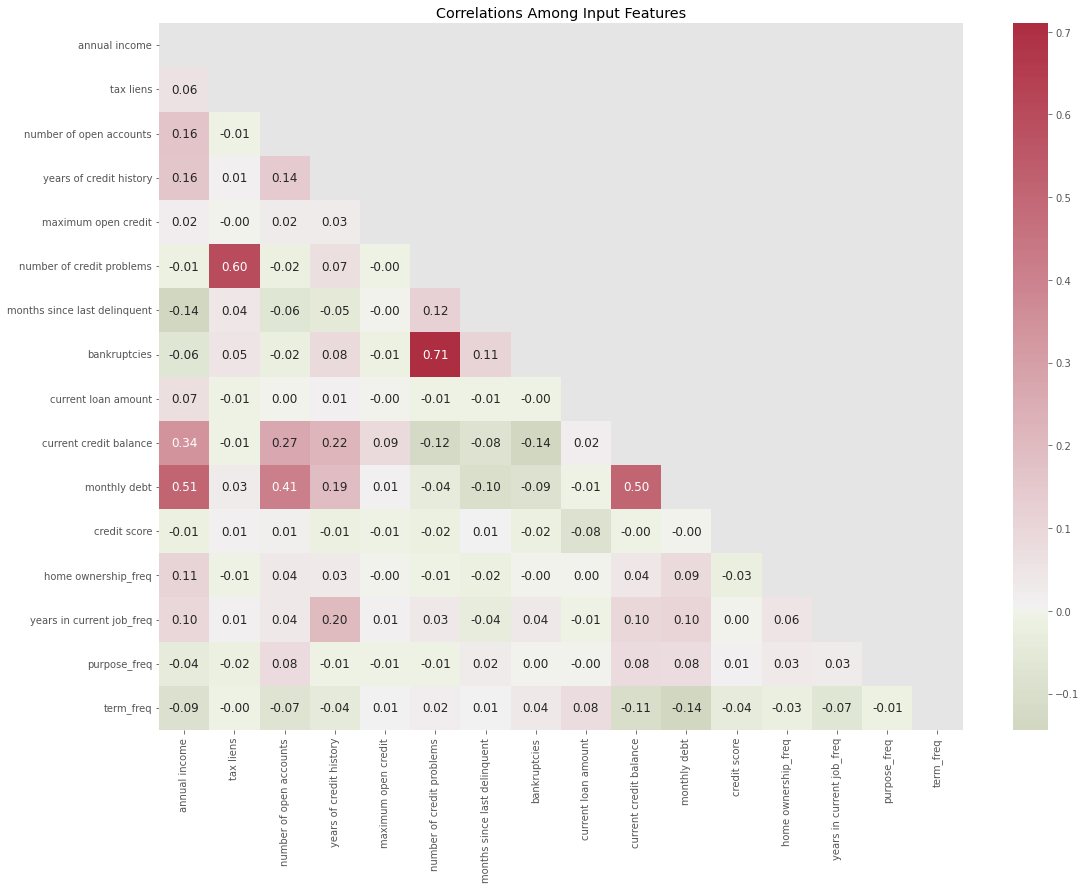

In [76]:
mc.corr_sign(tr, 'target')

In [77]:
tr['target'].value_counts()

0    5387
1    2113
Name: target, dtype: int64

In [28]:
model = fit_kfold(tr,threshold=0.4, fold=10)

0.6798367202921227

In [62]:
subb(test, model)

In [78]:
train = tr
test = ts

In [79]:
stat_train = mc.stat_frame(tr)
stat_train.head(n=tr.shape[1])

,count,max,quantile_99,max_vs_quantile_99,min,quantile_1,min_vs_quantile_1,nunique,isna_sum,dtype
annual income,7500,10149344.0,4225966.7,75,164597.0,364466.17,75,5479,0,float64
tax liens,7500,7.0,1.0,51,0.0,0.0,0,8,0,float64
number of open accounts,7500,43.0,27.0,62,2.0,3.0,28,39,0,float64
years of credit history,7500,57.7,40.401,75,4.0,6.5,70,408,0,float64
maximum open credit,7500,1304726170.0,3568459.4,75,0.0,17269.78,75,6963,0,float64
number of credit problems,7500,7.0,2.0,56,0.0,0.0,0,8,0,float64
months since last delinquent,7500,118.0,79.0,59,0.0,2.0,45,151,0,float64
bankruptcies,7500,4.0,1.0,54,0.0,0.0,0,6,0,float64
current loan amount,7500,99999999.0,99999999.0,0,11242.0,43185.56,75,5386,0,float64
current credit balance,7500,6506797.0,1483079.39,75,0.0,1443.81,75,6592,0,float64


In [80]:
# stat_test = mc.stat_frame(ts)

In [81]:
tr = mc.percentile_99_1(tr, flag=True)
ts = mc.percentile_99_1(ts, flag=True)

In [67]:
model = fit_kfold(tr,threshold=0.4, fold=10)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.6932048993660368
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6859947770577426
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.661994741886414
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6545735916081209
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6819808492117228
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6792990354263204
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6606450421616299
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.7087132636599566
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6946324612471066
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6719769236164691
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.679301558524152
Признаки для удаления set()


In [68]:
subb(test, model)

0.6801269553695585

In [82]:
train = tr
test = ts

In [83]:
train.shape, test.shape

((7500, 17), (2500, 16))

# new features

In [84]:
train.head()

,annual income,tax liens,number of open accounts,years of credit history,maximum open credit,number of credit problems,months since last delinquent,bankruptcies,current loan amount,current credit balance,monthly debt,credit score,home ownership_freq,years in current job_freq,purpose_freq,term_freq,target
0,482087.0,0.0,11.0,26.3,685960.0,1.0,38.906,1.0,99999999.0,47386.0,7914.0,749.0,0.086267,0.091000,0.792533,0.7408,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,34.160,0.0,264968.0,394972.0,18373.0,737.0,0.086267,0.327115,0.792533,0.2592,1
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,31.643,0.0,99999999.0,308389.0,13651.0,742.0,0.484933,0.047552,0.792533,0.7408,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,40.789,1.0,121396.0,95855.0,11338.0,694.0,0.086267,0.059756,0.792533,0.7408,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,40.789,0.0,125840.0,93309.0,7180.0,719.0,0.427200,0.047552,0.792533,0.7408,0


In [85]:
train_cat

,home ownership,years in current job,purpose,term
0,Own Home,NaN,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term
...,...,...,...,...
7495,Rent,< 1 year,other,Short Term
7496,Home Mortgage,1 year,debt consolidation,Long Term
7497,Rent,6 years,buy a car,Short Term
7498,Home Mortgage,NaN,debt consolidation,Short Term


In [86]:
train_cat['years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: years in current job, dtype: int64

### если человек больше года на работе это хорошо

In [87]:
train_cat['years in current job'].isna().sum()

371

In [88]:
train['years in current job'] = train_cat['years in current job']
test['years in current job'] = test_cat['years in current job']

In [89]:
train['flag_good_job'] = np.where(train['years in current job'] != "< 1 year", 1, 0)
test['flag_good_job'] = np.where(test['years in current job'] != "< 1 year", 1, 0)

In [90]:
train = train.drop('years in current job', axis=1)
test = test.drop('years in current job', axis=1)

In [91]:
train.columns

Index(['annual income', 'tax liens', 'number of open accounts',
       'years of credit history', 'maximum open credit',
       'number of credit problems', 'months since last delinquent',
       'bankruptcies', 'current loan amount', 'current credit balance',
       'monthly debt', 'credit score', 'home ownership_freq',
       'years in current job_freq', 'purpose_freq', 'term_freq', 'target',
       'flag_good_job'],
      dtype='object')

### ипотека на дом и имеет ипотеку это одно и тоже

In [92]:
train = train.drop('home ownership_freq', axis=1)
test = test.drop('home ownership_freq', axis=1)

In [93]:
train['home ownership'] = train_cat['home ownership']
test['home ownership'] = test_cat['home ownership']

In [94]:
tr = train.copy()
ts = test.copy()

In [95]:
d = {'Home Mortgage':'Home Mortgage', 'Rent':'Rent', 'Own Home': 'Own Home', 'Have Mortgage': 'Home Mortgage'}
tr['home ownership'] = tr['home ownership'].apply(lambda x: d[x])
ts['home ownership'] = ts['home ownership'].apply(lambda x: d[x])

In [96]:
test_cat['home ownership'].value_counts()

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: home ownership, dtype: int64

In [97]:
ts['home ownership'].value_counts()

Home Mortgage    1232
Rent             1020
Own Home          248
Name: home ownership, dtype: int64

In [98]:
train = tr
test = ts

In [99]:
train = mc.object_to_freq(train, ['home ownership'])
test = mc.object_to_freq(test, ['home ownership'])

train = train.drop('home ownership', axis=1)
test = test.drop('home ownership', axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.15it/s]


In [100]:
train['years_since_last_delinquent'] = train['months since last delinquent'] / 365
test['years_since_last_delinquent'] = test['months since last delinquent'] / 365


In [113]:
train.shape, test.shape

((7500, 19), (2500, 18))

In [114]:
model = fit_kfold(train,threshold=0.41, fold=10)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.6807498527200626
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6815763789358915
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6716932356742783
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6572641982256064
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6662284905345163
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6951788901687345
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6613792436405843
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.6875657571719155
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6744143227888055
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6623325384021885
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6738382908262583
Признаки для удаления set()
Лучших 5  признаков: {'credit score', 'term_freq', 'maximum open credit', 'annual income', 'current loan amount'}


In [254]:
train.shape, test.shape

((7500, 19), (2500, 18))

In [115]:
subb(test, model)

In [105]:
train.to_csv("data/train_best.csv", index=False)
test.to_csv("data/test_best.csv", index=False)

* на данном этапе score 0.63843 на liderboard, при старых параметрах catboost

* Home Ownership - домовладение  
* Annual Income - годовой доход  
* Years in current job - количество лет на текущем месте работы  
* Tax Liens - налоговые обременения  
* Number of Open Accounts - количество открытых счетов  
* Years of Credit History - количество лет кредитной истории  
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)  
* Number of Credit Problems - количество проблем с кредитом  
* Months since last delinquent - количество месяцев с последней просрочки платежа  
* Bankruptcies - банкротства  
* Purpose - цель кредита  
* Term - срок кредита  
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)  
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)  
* Monthly Debt - ежемесячный долг  
* Credit Score - баллы кредитного рейтинга  
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [18]:
os.listdir("data")

['data_kmeans.csv',
 'sample_submission.csv',
 'test.csv',
 'test_best.csv',
 'test_dr_f.csv',
 'test_kmeans.csv',
 'test_max_sign.csv',
 'test_new.csv',
 'train.csv',
 'train_best.csv',
 'train_dr_f.csv',
 'train_kmeans.csv',
 'train_max_sign.csv',
 'train_new.csv']

In [8]:
train = pd.read_csv("data/train_best.csv")
test = pd.read_csv("data/test_best.csv")
sub = pd.read_csv("data/sample_submission.csv")

train.shape, test.shape

((7500, 19), (2500, 18))

In [13]:
model, dict_fold = fit_kfold(train,threshold=0.4, fold=10)

TypeError: CatBoostClassifier.__init__() got an unexpected keyword argument 'random state'

0.679

In [56]:
subb(test, model)

In [52]:
# tr['ratio_income_to_tax_liens'] = tr['tax liens'] / tr['annual income'] 
# ts['ratio_income_to_tax_liens'] =  ts['tax liens'] / ts['annual income']

In [53]:
# tr["ratio_income_to_loan"] = tr['current loan amount'] / tr['annual income'] 
# ts["ratio_income_to_loan"] = ts['current loan amount'] / ts['annual income'] 

In [55]:
# model = fit_kfold(tr,threshold=0.4, fold=10)

In [32]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()


    # Отношение между основными фин. показателями
    X['ratio_income_to_tax_liens'] = X['annual income'] * X['tax liens']
    X["ratio_income_to_loan"] = X['annual income'] / X['current loan amount']
#     X["total_salary_annuity"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X['ratio_credit_to_salary'] = X['current loan amount'] / X['annual income']
    X["ratio_loan_amount_to_monthly_debt"] = X["current loan amount"] / X["monthly debt"]
    X["ratio_loan_amount_to_months_since_last_delinquent"] = X["current loan amount"] / X["months since last delinquent"]
    X["ratio_loan_amount_to_number_of_open_accounts"] = X["current loan amount"] / X["number of open accounts"]
    X["ratio_loan_amount_to_years_in_current_job"] = X["current loan amount"] / X["years in current job_freq"]
    X["ratio_loan_amount_to_home_ownership"] = X["current loan amount"] / X["home ownership_freq"]
    X["ratio_loan_amount_to_number_of_credit_problems"] = X["current loan amount"] / X["number of credit problems"]

    # Отношение врменных признаков
    X["ratio_annual_income_to_experience"] = X["annual income"] / X["years_since_last_delinquent"]
    X["ratio_current_loan_amount_to_region_population"] = X["current loan amount"] * X["years_since_last_delinquent"]
    X["ratio_number_of_open_accounts_to_years_since_last_delinquent"] = X["number of open accounts"] / X["years_since_last_delinquent"]
#     X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["credit score"] * X["current loan amount"]


    return X


In [33]:
train = create_client_profile_features(train)
test = create_client_profile_features(test)

In [34]:
train.shape, test.shape

((7500, 32), (2500, 31))

In [35]:
# model = fit_kfold(train,threshold=0.4, fold=10)

In [36]:
# subb(test)

# group

In [37]:
tr = train.copy()
ts = test.copy()

In [38]:
def split_data_group(features: List, data):
    features_dict = dict()
    for i in tqdm(features):
        len_feature = data[i].nunique()
        list_feture = np.sort(data[i].unique())
        perc_02 = int(len_feature * 0.2)
        perc_04 = int(len_feature * 0.4)
        perc_06 = int(len_feature * 0.6)
        perc_08 = int(len_feature * 0.8)
        pp = -2
        for perc in [perc_02, perc_04, perc_06, perc_08, pp]:
            if perc == perc_02:
                list_f = list_feture[:perc]
            elif perc == perc_04:
                list_f = list_feture[perc_02:perc]
            elif perc == perc_06:
                list_f = list_feture[perc_04:perc]
            elif perc == perc_08:
                list_f = list_feture[perc_06:perc]
            elif perc == pp:
                list_f = list_feture[perc_08:]
            for p in list_f:
                features_dict[p] = np.sum(list_f)
        data[f'group_{i}'] = data[i].apply(lambda x: features_dict[x])
    return data

In [39]:
tr = split_data_group(tr.drop('target', axis=1)[['credit score', 'annual income', 'term_freq']].columns, tr)
ts = split_data_group(ts[['credit score', 'annual income', 'term_freq']].columns, ts)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [40]:
tr.shape, ts.shape

((7500, 35), (2500, 34))

In [67]:
model = fit_kfold(tr,threshold=0.4, fold=10, best_sign=10)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.6918639924733359
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6760017233950882
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6601394543168408
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.65323268471542
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.685691424350869
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.7000105513985
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6511663691758478
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.7110016132426177
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6893455846250963
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.670048046573613
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6788501444267229
Признаки для удаления set()
Лучших 10  признаков: {'maximum open credit', 'ratio_income_to_loan', 'annual income', 'credit score', 'group_credit score', 'current loan amount', 'group_annual income', 'number of open accounts', 'term_freq', 'monthly debt', 'home ownership_freq', 'g

In [134]:
# subb(ts, model)

In [41]:
train = tr
test = ts

# kmeans

## cdist

In [135]:
# train.head()

,annual income,tax liens,number of open accounts,years of credit history,maximum open credit,number of credit problems,months since last delinquent,bankruptcies,current loan amount,current credit balance,monthly debt,credit score,years in current job_freq,purpose_freq,term_freq,target,flag_good_job,home ownership_freq,years_since_last_delinquent
0,482087.0,0.0,11.0,26.3,685960.0,1.0,38.906,1.0,99999999.0,47386.0,7914.0,749.0,0.091000,0.792533,0.7408,0,1,0.086267,0.106592
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,34.160,0.0,264968.0,394972.0,18373.0,737.0,0.327115,0.792533,0.2592,1,1,0.086267,0.093589
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,31.643,0.0,99999999.0,308389.0,13651.0,742.0,0.047552,0.792533,0.7408,0,1,0.486533,0.086693
3,805068.0,0.0,8.0,22.5,147400.0,1.0,40.789,1.0,121396.0,95855.0,11338.0,694.0,0.059756,0.792533,0.7408,0,1,0.086267,0.111751
4,776264.0,0.0,13.0,13.6,385836.0,1.0,40.789,0.0,125840.0,93309.0,7180.0,719.0,0.047552,0.792533,0.7408,0,1,0.427200,0.111751


In [198]:
# mc.dist_kmeans(tr[['maximum open credit', 'ratio_income_to_loan', 'annual income', 'credit score', 'group_credit score', 'current loan amount', 'group_annual income', 'number of open accounts', 'term_freq', 'monthly debt', 'home ownership_freq', 'group_term_freq']], 10)

In [199]:
# tr = train.copy()
# ts = test.copy()

In [70]:
# best = ['maximum open credit', 'ratio_income_to_loan', 'annual income', 'credit score', 'group_credit score', 'current loan amount', 'group_annual income', 'number of open accounts', 'term_freq', 'monthly debt', 'home ownership_freq', 'group_term_freq']
# for i in best:
#     kmeans = KMeans(n_clusters=5, random_state=42).fit(tr[best])
#     tr[f'kmeans_{i}'] = kmeans.labels_


In [71]:
# for i in best:
#     kmeans = KMeans(n_clusters=4, random_state=42).fit(ts[best])
#     ts[f'kmeans_{i}'] = kmeans.labels_

In [72]:
# tr.shape, ts.shape

((7500, 36), (2500, 35))

In [200]:
# model = fit_kfold(tr,threshold=0.4, fold=10, best_sign=10)

In [201]:
# subb(ts, model)

# categorical

In [265]:
train.columns

Index(['annual income', 'tax liens', 'number of open accounts',
       'years of credit history', 'maximum open credit',
       'number of credit problems', 'months since last delinquent',
       'bankruptcies', 'current loan amount', 'current credit balance',
       'monthly debt', 'credit score', 'years in current job_freq',
       'purpose_freq', 'term_freq', 'target', 'flag_good_job',
       'home ownership_freq', 'years_since_last_delinquent',
       'ratio_income_to_tax_liens', 'ratio_income_to_loan',
       'ratio_credit_to_salary', 'ratio_loan_amount_to_monthly_debt',
       'ratio_loan_amount_to_months_since_last_delinquent',
       'ratio_loan_amount_to_number_of_open_accounts',
       'ratio_loan_amount_to_years_in_current_job',
       'ratio_loan_amount_to_home_ownership',
       'ratio_loan_amount_to_number_of_credit_problems',
       'ratio_annual_income_to_experience',
       'ratio_current_loan_amount_to_region_population',
       'ratio_number_of_open_accounts_to_years

In [266]:
base_columns

Index(['annual income', 'tax liens', 'number of open accounts',
       'years of credit history', 'maximum open credit',
       'number of credit problems', 'months since last delinquent',
       'bankruptcies', 'current loan amount', 'current credit balance',
       'monthly debt', 'home ownership_freq', 'years in current job_freq',
       'purpose_freq', 'term_freq', 'target'],
      dtype='object')

In [267]:
aggs = []
for i in train[base_columns].columns:
    if i == "target":
        continue
    if type(i) == int:
        continue
    if train[i].nunique() < 15:
        aggs.append(i)
aggs
print(len(aggs))
for i in aggs:
    
    print("*"*20)
    print(i)
    print("train : ", train[i].nunique())
    print(train[i].unique())
    
    print("test : ", test[i].nunique())
    print(test[i].unique())
    print(np.sort(train[i].unique()) == np.sort(test[i].unique()))

7
********************
tax liens
train :  2
[0. 1.]
test :  2
[0. 1.]
[ True  True]
********************
number of credit problems
train :  3
[1. 0. 2.]
test :  3
[0. 1. 2.]
[ True  True  True]
********************
bankruptcies
train :  2
[1. 0.]
test :  2
[0. 1.]
[ True  True]
********************
home ownership_freq
train :  3
[0.08626667 0.48653333 0.4272    ]
test :  3
[0.408  0.4928 0.0992]
[False False False]
********************
years in current job_freq
train :  13
[0.091      0.3271146  0.04755225 0.05975593 0.05554776 0.07238042
 0.07069715 0.07897321 0.06578763 0.08696872 0.09889185 0.03633048
 0.103     ]
test :  12
[0.06296603 0.06338028 0.09444905 0.33554267 0.05675228 0.07000829
 0.08574979 0.08782104 0.04101077 0.04432477 0.05799503 0.091     ]
False
********************
purpose_freq
train :  9
[0.79253333 0.08866667 0.05493333 0.00493333 0.0128     0.00453333
 0.0172     0.00946667 0.00533333]
test :  8
[0.7892 0.0056 0.056  0.096  0.0136 0.0108 0.0076 0.012 ]
False
**

elementwise comparison failed; this will raise an error in the future.


In [268]:
for i in test_cat.columns:
    print(i, test_cat[i].isna().sum())
    print(test_cat[i].value_counts())

home ownership 0
Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: home ownership, dtype: int64
years in current job 86
10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: years in current job, dtype: int64
purpose 0
debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: purpose, dtype: int64
term 0
Short Term    1861
Long Term      639
Name: term, dtype: int64


In [42]:
train_cat['years in current job'] = train_cat['years in current job'].fillna('10+ years')
test_cat['years in current job'] = test_cat['years in current job'].fillna('10+ years')

In [43]:
aggs = []
for i in train_cat.columns:
    if i == "target":
        continue
    if type(i) == int:
        continue
    if train_cat[i].nunique() < 15:
        aggs.append(i)
aggs
print(len(aggs))
for i in aggs:
    
    print("*"*20)
    print(i)
    print("train : ", train_cat[i].nunique())
    print(train_cat[i].unique())
    
    print("test : ", test_cat[i].nunique())
    print(test_cat[i].unique())
    print(np.sort(train_cat[i].unique()) == np.sort(test_cat[i].unique()))

3
********************
home ownership
train :  4
['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
test :  4
['Rent' 'Home Mortgage' 'Own Home' 'Have Mortgage']
[ True  True  True  True]
********************
years in current job
train :  11
['10+ years' '8 years' '6 years' '7 years' '5 years' '1 year' '< 1 year'
 '4 years' '3 years' '2 years' '9 years']
test :  11
['4 years' '1 year' '3 years' '10+ years' '6 years' '5 years' '< 1 year'
 '2 years' '9 years' '8 years' '7 years']
[ True  True  True  True  True  True  True  True  True  True  True]
********************
term
train :  2
['Short Term' 'Long Term']
test :  2
['Short Term' 'Long Term']
[ True  True]


In [44]:
train[train_cat.columns] = train_cat
test[test_cat.columns] = test_cat

In [45]:
aggs = ['number of credit problems', 'term', 'years in current job', 'home ownership']

In [46]:
train[aggs] = train[aggs].astype("str")
test[aggs] = test[aggs].astype("str")

In [274]:
# transformer = CategoricalFrequencyTransformer(use_cols=aggs)
train = mc.object_to_freq(train, aggs)
test = mc.object_to_freq(test, aggs)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 333.23it/s]


In [275]:
train.shape, test.shape

((7500, 40), (2500, 39))

In [47]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [48]:
onehotencoder = OneHotEncoder()

In [49]:
data_new = onehotencoder.fit_transform(train[aggs])
data_new = pd.DataFrame(data_new.toarray())
train[data_new.columns] = data_new

In [50]:
data_new_t = onehotencoder.fit_transform(test[aggs])
data_new_t = pd.DataFrame(data_new_t.toarray())
test[data_new_t.columns] = data_new_t

In [51]:
train.shape, test.shape

((7500, 59), (2500, 58))

In [52]:
le = dict()
labelencoder = LabelEncoder()
for col in train[aggs].columns:
    data_new = labelencoder.fit_transform(train[col].values)
    le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
    train[f'le_{col}'] = train[col].apply(lambda x: le[x])

In [53]:
le = dict()
labelencoder = LabelEncoder()
for col in test[aggs].columns:
    data_new = labelencoder.fit_transform(test[col].values)
    le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
    test[f'le_{col}'] = test[col].apply(lambda x: le[x])

In [54]:
train.shape, test.shape

((7500, 63), (2500, 62))

In [284]:
# train.head()

In [285]:
# train.info()

In [55]:
train = train.drop(['term', 'years in current job', 'home ownership'], axis=1)
test = test.drop(['term', 'years in current job', 'home ownership'], axis=1)


train = train.drop("purpose", axis=1)
test = test.drop("purpose", axis=1)

In [56]:
train['number of credit problems'] = train['number of credit problems'].astype("float32")
test['number of credit problems'] = test['number of credit problems'].astype("float32")

In [57]:
train.shape, test.shape

((7500, 59), (2500, 58))

In [290]:
model = fit_kfold(train,threshold=0.4, fold=10, best_sign=5)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.694950276534569
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6651821435166052
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6728143217648973
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6533338022843778
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6890898539510592
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6950601869356101
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6657976417624353
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.7097829136564494
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6993494423791823
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.669688574033808
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6815049156818993
Признаки для удаления set()
Лучших 5  признаков: {'ratio_loan_amount_to_monthly_debt', 'group_credit score', 'group_annual income', 'annual income', 'credit score', 'maximum open credit', 'ratio_loan_amount_to_number_of_open_accounts'}


In [228]:
subb(test, model)

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 31 should be feature with name group_credit score (found tax liens_freq).

## stat features

In [291]:
train.to_csv('data/train_new.csv', index=False)
test.to_csv('data/test_new.csv', index=False)

In [207]:
train = pd.read_csv("data/train_new.csv")
test = pd.read_csv("data/test_new.csv")

In [58]:
train.shape, test.shape

((7500, 59), (2500, 58))

In [59]:
best = ['ratio_loan_amount_to_monthly_debt', 'group_credit score', 'group_annual income', 'annual income', 'credit score', 'maximum open credit', 'ratio_loan_amount_to_number_of_open_accounts']
# best = list(dict_f.keys())[:5]
best = best[:3]
best

['ratio_loan_amount_to_monthly_debt',
 'group_credit score',
 'group_annual income']

In [60]:
%%time
funk = 'mean'
j = 0
for feature in tqdm(best):

    data_grouped = train.groupby(train[feature])
    stats = data_grouped.agg(funk)

    stats.columns = [f"{j}_{i}_{funk}".upper() for i in stats]
    stats = stats.reset_index()
    
    train = train.merge(stats, how="left", on=feature)
    j += 1
print(train.shape)
print("test...")
j = 0
for feature in tqdm(best):

    data_grouped = test.groupby(test[feature])
    stats = data_grouped.agg(funk)

    stats.columns = [f"{j}_{i}_{funk}".upper() for i in stats]
    stats = stats.reset_index()
    
    test = test.merge(stats, how="left", on=feature)
    j += 1
print(test.shape)


  0%|          | 0/3 [00:00<?, ?it/s]

(7500, 465)
test...


  0%|          | 0/3 [00:00<?, ?it/s]

(2500, 457)
Wall time: 933 ms


In [61]:
cols1, cols2 = train.columns, test.columns

In [62]:
cols3 = [i for i in cols1 if i in cols2]
target = train['target']
print(len(cols3))

457


In [63]:
train = train[cols3]
test = test[cols3]
train['target'] = target

In [64]:
train.shape, test.shape

((7500, 458), (2500, 457))

In [65]:
train.to_csv("data/train_max_sign.csv", index=False)
test.to_csv("data/test_max_sign.csv", index=False)

In [69]:
a = [1,2,3,4,5,5,5,5]
print(list(set(a)))

[1, 2, 3, 4, 5]


In [71]:
%%time
model = fit_kfold(train,threshold=0.4, fold=10, best_sign=5)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.7109752130063572
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6693499459240827
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6688355652472104
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6568861064460252
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6465809072444145
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.667907921462424


KeyboardInterrupt: 

In [66]:
%%time
model = fit_kfold(train,threshold=0.4, fold=10, best_sign=5)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.697733207888929
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.661159422838502
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6659075521634763
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6409710803752782
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6915606397664624
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.696502211397269
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6315847321263706
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.7078540366135933
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6914147436347058
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.662753384302448


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


TypeError: unhashable type: 'list'

In [ ]:
subb(test, model)

In [ ]:
def shap_shap(X_train, model, shap_limit=0):
    np.random.seed(10)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Суммированная важность признаков
    shap.summary_plot(
        shap_values, X_train, plot_type="bar", max_display=50)
    
    shap_values_importance = pd.DataFrame({
    "importance": np.abs(shap_values).mean(axis=0),
    "feature": X_train.columns
        })
    shap_values_importance = shap_values_importance.sort_values(
        by="importance", ascending=False
        )
    shap_values_importance = shap_values_importance.reset_index(drop=True) 
    
    
#     print(shap_values_importance)
    # Набор топ признаков
    best_feature = shap_values_importance.feature.to_list()
    dict_features = dict(zip(best_feature, shap_values_importance["importance"]))
    # Набор признаков для удаления
    features_to_drop = shap_values_importance[shap_values_importance["importance"] <= shap_limit]
    features_to_drop = features_to_drop.feature.to_list()
    
    return features_to_drop, dict_features

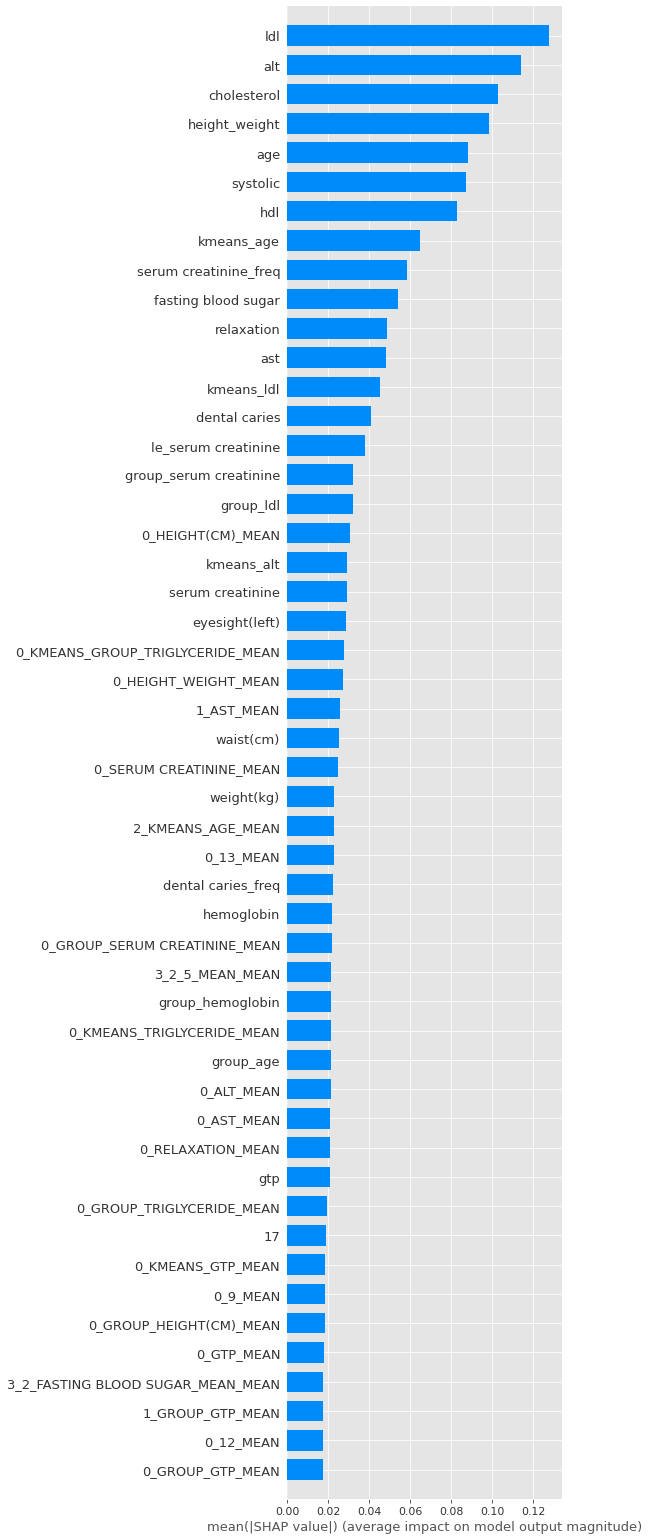

In [15]:
bad_sign, dict_f = shap_shap(X_train, model)

In [18]:
train.to_csv("data/train_new_all.csv", index=False)
test.to_csv("data/test_new_all.csv", index=False)

In [19]:
import json
with open('dict_features.json', 'w') as fp:
    json.dump(dict_f, fp)

In [6]:
os.listdir("data")

['sample_submission.csv',
 'test.csv',
 'test_new.csv',
 'test_new.zip',
 'test_new_1.csv',
 'test_new_all.csv',
 'train.csv',
 'train_new.csv',
 'train_new_1.csv',
 'train_new_all.csv']

In [8]:
train = pd.read_csv("data/train_new_all.csv")
test = pd.read_csv("data/test_new_all.csv")

In [9]:
train.shape, test.shape

((159256, 2434), (106171, 2433))

In [11]:
dict_features = pd.read_json("dict_features.json", orient='index')
dict_features = dict_features.reset_index()
dict_f = dict(zip(dict_features['index'], dict_features[0]))
# dict_f

In [17]:
dict_f.values() 

False

In [22]:
features = [k for k, v in dict_f.items() if v != 0]

In [25]:
t = train[features].copy()
t['smoking'] = train['smoking']

In [26]:
t.shape

(159256, 1667)

In [28]:
%%time
model, X_train = fit_score(t)

x_train.shape: (101923, 1666) x_valid.shape:  (31852, 1666) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 1666) y_test.shape:  (25481,)
0:	total: 326ms	remaining: 27m 10s
500:	total: 2m 15s	remaining: 20m 15s
1000:	total: 4m 22s	remaining: 17m 29s
1500:	total: 6m 28s	remaining: 15m 5s
2000:	total: 8m 30s	remaining: 12m 45s
2500:	total: 10m 32s	remaining: 10m 32s
3000:	total: 12m 33s	remaining: 8m 22s
3500:	total: 14m 36s	remaining: 6m 15s
4000:	total: 16m 38s	remaining: 4m 9s
4500:	total: 18m 40s	remaining: 2m 4s
4999:	total: 20m 43s	remaining: 0us
roc_auc_score:  0.7833167239584812
confusion_matrix:  [[13584  4199]
 [ 2775 11294]]
accuracy_score:  0.7810498555820671
test score:  0.78264
Wall time: 21min 7s


0.78076

In [29]:
target = train['smoking']
train = train[features]
train['smoking'] = target
test = test[features]

In [30]:
train.shape, test.shape

((159256, 1667), (106171, 1666))

In [31]:
train.to_csv("data/train_new_all.csv", index=False)
test.to_csv("data/test_new_all.csv", index=False)

In [ ]:
bad, dict_features = shapr_shap(model, X_train)

### test

In [16]:
def fit_score(X):
    x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(X, "smoking")

    params = {
        "n_estimators": 5000,
        "learning_rate": 0.01,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": 500,
        "max_depth": 6,
        "l2_leaf_reg": 10,
        "early_stopping_rounds": 50,
        "thread_count": 6,
        "random_seed": 42
        }
    model, rocauc_score = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=params)
    pred = model.predict_proba(x_test)[:,1]
    pred = np.where(pred > 0.5, 1, 0)
    print("test score: ", round(roc_auc_score(pred, y_test), 5))
    return model, x_train, rocauc_score

In [17]:
data_scoring = pd.DataFrame(columns=["del_sign", "scoreAUC", "check_best"])
check_cols = list(dict_f.keys())
check_cols.reverse()
all_sign_roc = 0.77874
for col in tqdm(range(check_cols)):
    t = train.copy()
    t = t.drop(col, axis=1)
    model, x_train, rocauc_score = fit_score(t)
    d = dict()
    d["del_sign"] = col
    d["scoreAUC"] = rocauc_score
    d["check_best"] = 1 if rocauc_score > all_sign_roc else 0
    if rocauc_score > all_sign_roc:
        print("на признаке {}, auc: {}, он больше на {}".format(col, rocauc_score, rocauc_score-all_sign_roc))
    data_scoring  = data_scoring.append(d)
        

AttributeError: 'list' object has no attribute 'reverce'

In [ ]:
data_scoring.to_csv("data/data_scoring.csv")

## transformer

In [56]:
def transformer(train, test, cont_cols, target):
    '''
    Алгоритм применяет множественные преобразования к выбранным столбцам и 
    находит наилучшее преобразование, используя одну переменную производительности модели  
    '''
    train_copy = train.copy()
    test_copy = test.copy()
    for col in cont_cols:
                
        # Log Transformation after MinMax Scaling (keeps data between 0 and 1)
        train_copy["log_"+col] = np.log1p(train_copy[col])
        test_copy["log_"+col] = np.log1p(test_copy[col])
        
        # Square Root Transformation
        train_copy["sqrt_"+col] = np.sqrt(train_copy[col])
        test_copy["sqrt_"+col] = np.sqrt(test_copy[col])
        
        # Box-Cox transformation
        epsilon = 1e-5
        transformer = PowerTransformer(method='box-cox')

        train_copy["bx_cx_" + col] = transformer.fit_transform(train_copy[[col]] + epsilon)
        test_copy["bx_cx_" + col] = transformer.fit_transform(test_copy[[col]] + epsilon)
        
        # Yeo-Johnson transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_"+col] = transformer.transform(test_copy[[col]])
        
        # Log to power transformation
        train_copy["log_sqrt"+col] = np.log1p(train_copy["sqrt_"+col])
        test_copy["log_sqrt"+col] = np.log1p(test_copy["sqrt_"+col])
        
        temp_cols = [col, "log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col,  "pow_"+col , "pow2_"+col,"log_sqrt"+col]
        
        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[temp_cols])
        x_pca_test = pca.transform(test_copy[temp_cols])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        temp_cols.append(col+"_pca_comb")
        
        test_copy = test_copy.reset_index(drop=True)
        
        train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
        test_copy = pd.concat([test_copy, x_pca_test], axis='columns')
        
    return train_copy, test_copy

In [57]:
train.shape, test.shape

((159256, 63), (106171, 62))

In [59]:
train = mc.transformer(train, aggs, "smoking")
test = mc.transformer(test, aggs, "smoking")

divide by zero encountered in log
divide by zero encountered in log
overflow encountered in power
overflow encountered in multiply
divide by zero encountered in log
overflow encountered in power
overflow encountered in multiply


In [60]:
train.shape, test.shape

((159256, 103), (106171, 102))

In [61]:
model, X_train = fit_score(train)

x_train.shape: (101923, 102) x_valid.shape:  (31852, 102) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 102) y_test.shape:  (25481,)
0:	total: 16.5ms	remaining: 1m 22s
500:	total: 7.99s	remaining: 1m 11s
1000:	total: 15.9s	remaining: 1m 3s
1500:	total: 24.1s	remaining: 56.2s
2000:	total: 32.4s	remaining: 48.5s
2500:	total: 40.5s	remaining: 40.5s
3000:	total: 48.8s	remaining: 32.5s
3500:	total: 57.2s	remaining: 24.5s
4000:	total: 1m 5s	remaining: 16.4s
4500:	total: 1m 13s	remaining: 8.2s
4999:	total: 1m 22s	remaining: 0us
roc_auc_score:  0.7842802689278111
confusion_matrix:  [[13538  4300]
 [ 2668 11346]]
accuracy_score:  0.7812382267989452
test score:  0.77978


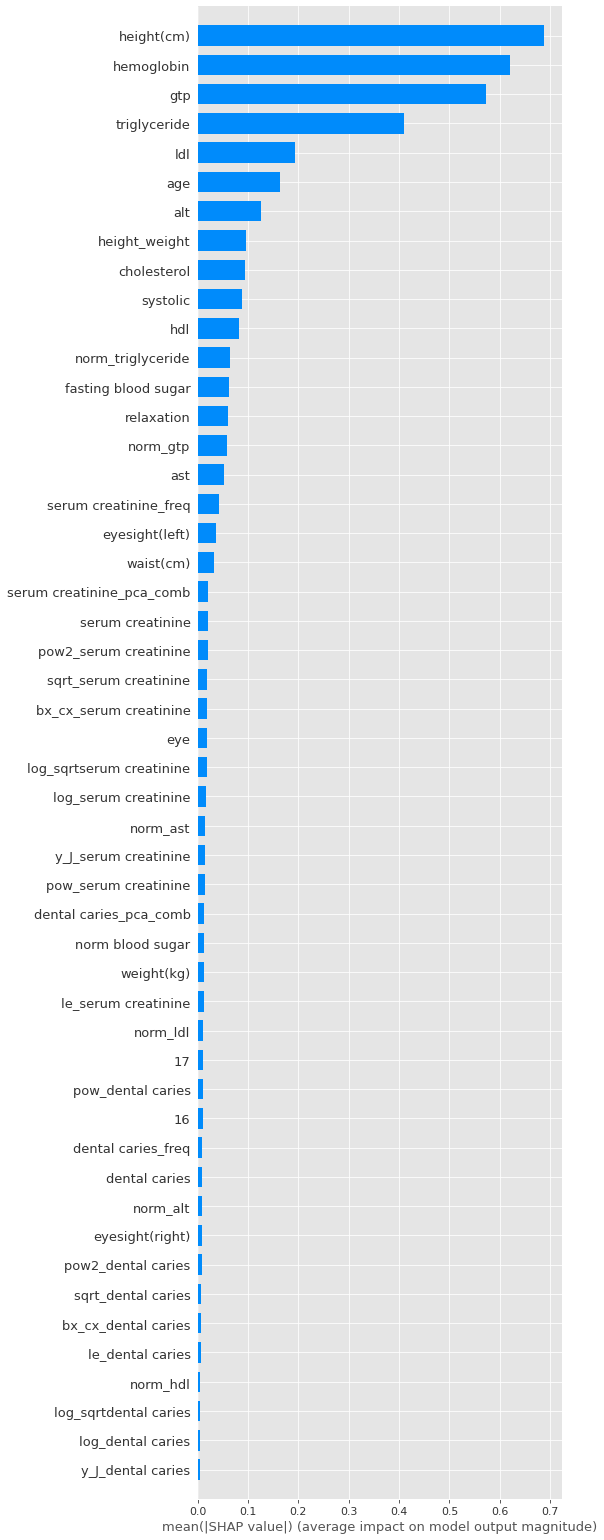

In [62]:
bad_features, best_features = mc.shap(model, X_train)

In [63]:
bad_features

['y_J_hearing(right)', 'bx_cx_hearing(left)', 'y_J_hearing(left)', 7]

In [ ]:
# train_t = train.copy()
# test_t = test.copy()

In [64]:
train = train.drop(bad_features, axis=1)
test = test.drop(bad_features, axis=1)

In [65]:
model, X_train = fit_score(train)

x_train.shape: (101923, 98) x_valid.shape:  (31852, 98) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 98) y_test.shape:  (25481,)
0:	total: 19ms	remaining: 1m 35s
500:	total: 8.44s	remaining: 1m 15s
1000:	total: 16.9s	remaining: 1m 7s
1500:	total: 25.7s	remaining: 59.8s
2000:	total: 34.3s	remaining: 51.5s
2500:	total: 42.9s	remaining: 42.8s
3000:	total: 51.5s	remaining: 34.3s
3500:	total: 1m	remaining: 25.8s
4000:	total: 1m 9s	remaining: 17.2s
4500:	total: 1m 17s	remaining: 8.63s
4999:	total: 1m 26s	remaining: 0us
roc_auc_score:  0.7848842410612629
confusion_matrix:  [[13543  4295]
 [ 2655 11359]]
accuracy_score:  0.7818033404495793
test score:  0.77963


In [66]:
train.to_csv("data/train_new_1.csv", index=False)
test.to_csv("data/test_new_1.csv", index=False)